In [37]:
import pandas as pd
import numpy as np
from numpy import mean

def get_metrics(prediction_dataframe, prediction_column, actual_column):

    e = prediction_dataframe[prediction_column].values - prediction_dataframe[actual_column].values

    ae, se, pe = abs(e), e**2, (e/prediction_dataframe[actual_column].values)

    mae, mse, mpe, ape = mean(ae), mean(se), mean(pe), (ae/prediction_dataframe[actual_column].values)

    rmse, mape = mse**0.5, mean(ape)

    return {'mae':mae, 'mse':mse, 'mpe':mpe, 'rmse':rmse, 'mape':mape}

In [38]:
full_data = pd.read_csv("all_monthly_london_data.csv").drop(columns="Unnamed: 0").set_index("date")
full_data.index = pd.to_datetime(full_data.index, format="%Y-%m-%d")

single_column = "avg_temp"

univariant_data = full_data[[single_column]]

univariant_data = univariant_data
univariant_data[single_column] = univariant_data[single_column].astype(float)

In [39]:
"""Data Structure:

For timeseries forecasting the date must be the index column.

The Data Provided for univarient and baseline forecasting must be a single timeseries with the dates in order.





"""

'Data Structure:\n\nFor timeseries forecasting the date must be the index column.\n\nThe Data Provided for univarient and baseline forecasting must be a single timeseries with the dates in order.\n\n\n\n\n\n'

In [40]:
"""
model_types of forecasting

1). Baselines
1). Univarient
2). Multivarient
3). Machine Learning
4). Deep Learning
"""

'\nmodel_types of forecasting\n\n1). Baselines\n1). Univarient\n2). Multivarient\n3). Machine Learning\n4). Deep Learning\n'

In [41]:
from statsforecast.models import (
    HistoricAverage,
    Naive,
    RandomWalkWithDrift,
    SeasonalNaive,
    WindowAverage,
    SeasonalWindowAverage,
    ADIDA,
    CrostonClassic,
    CrostonSBA,
    IMAPA,
    TSB,
    Theta,
    AutoARIMA,
    OptimizedTheta,
    AutoCES,
    AutoETS,
    DynamicTheta,
    SimpleExponentialSmoothing,
    SimpleExponentialSmoothingOptimized,
    SeasonalExponentialSmoothing,
    SeasonalExponentialSmoothingOptimized,
    Holt,
    HoltWinters,
)

baseline_model_dict = {
    "historic_average_baseline": HistoricAverage,
    "naive_baseline": Naive,
    "random_walk_baseline": RandomWalkWithDrift,
    # "window_average_baseline": WindowAverage,
}

seasonal_baseline_model_dict = {
    "seasonal_naive_baseline": SeasonalNaive,
    # "seasonal_window_average_baseline": SeasonalWindowAverage,
}

model_dict = {
    # 'adida_model':ADIDA,
    # 'croston_classic_model':CrostonClassic,
    # 'croston_sba_model':CrostonSBA,
    # 'imapa_model':IMAPA,
    # 'tsb_model':TSB,
    'theta_model':Theta,
    # 'auto_arima_model':AutoARIMA,
    'optimized_theta_model':OptimizedTheta,
    'auto_ces_model':AutoCES,
    'auto_ets_model':AutoETS,
    'dynamic_theta_model':DynamicTheta,
    # 'simple_exponential_smoothing_model':SimpleExponentialSmoothing,
    'simple_exponential_smoothing_optimized_model':SimpleExponentialSmoothingOptimized,
    # 'seasonal_exponential_smoothing_model':SeasonalExponentialSmoothing,
    'seasonal_exponential_smoothing_optimized_model':SeasonalExponentialSmoothingOptimized,
    'holt_model':Holt,
    'holt_winters_model':HoltWinters,
}

In [42]:
forecast_horizon = 14
baseline_result = {}
baseline_predictions = {}
baseline_inpredictions = {}
window = 365
seasonal = 365

actual_values = np.array([value[0] for value in univariant_data.values[-forecast_horizon:]])
train_data = np.array([value[0] for value in univariant_data.values[:-forecast_horizon]])



In [43]:
model_dict

model_result = {}
model_predictions = {}
model_inpredictions = {}

for model_name, model in model_dict.items():
    try:
        print(model_name)
        
        try:
            intmodel = model(season_length=seasonal)
        except:
            intmodel = model()
            
        fitted_model = intmodel.forecast(y=train_data, fitted=True, h=forecast_horizon)
        
        mean_prediction = fitted_model['mean']
        
        insample_prediction = fitted_model['fitted']
        insample_prediction[np.isnan(insample_prediction)] = 0

        prediction_dataframe = pd.DataFrame(mean_prediction, actual_values).reset_index()
        prediction_dataframe.columns = ["actual", "prediction"]

        model_result[model_name] = get_metrics(prediction_dataframe, 'prediction', 'actual')
        model_predictions[model_name] = mean_prediction
        model_inpredictions[model_name] = insample_prediction

    except Exception as e:
        print(e)
        print(model_predictions)

model_predictions_df = pd.DataFrame(model_predictions, index=univariant_data.index[-forecast_horizon:]).fillna(0)
model_result_df = pd.DataFrame(model_result).fillna(0)
model_inpredictions_df = pd.DataFrame(model_inpredictions, univariant_data.index[:-forecast_horizon]).fillna(0)

theta_model
optimized_theta_model
auto_ces_model
auto_ets_model
dynamic_theta_model
simple_exponential_smoothing_optimized_model
seasonal_exponential_smoothing_optimized_model
holt_model
holt_winters_model


In [44]:
for model_name, model in baseline_model_dict.items():
    
    print(model_name)
    
    if 'window' in model_name:
        intmodel = model(window_size=window)

    else:    
        intmodel = model()

    fitted_model = intmodel.forecast(y=train_data, fitted=True, h=forecast_horizon)
    
    mean_prediction = fitted_model['mean']
    insample_prediction = fitted_model['fitted']

    prediction_dataframe = pd.DataFrame(mean_prediction, actual_values).reset_index()
    prediction_dataframe.columns = ["actual", "prediction"]

    baseline_result[model_name] = get_metrics(prediction_dataframe, 'prediction', 'actual')

    baseline_predictions[model_name] = mean_prediction
    baseline_inpredictions[model_name] = insample_prediction

for model_name, model in seasonal_baseline_model_dict.items():
    print(model_name)
    
    if 'window' in model_name:
        intmodel = model(season_length=seasonal, window_size=1)

    else:    
        intmodel = model(season_length=seasonal)

    fitted_model = intmodel.forecast(y=train_data, fitted=True, h=forecast_horizon)
    
    mean_prediction = fitted_model['mean']
    
    insample_prediction = fitted_model['fitted']
    insample_prediction[np.isnan(insample_prediction)] = 0

    prediction_dataframe = pd.DataFrame(mean_prediction, actual_values).reset_index()
    prediction_dataframe.columns = ["actual", "prediction"]

    baseline_result[model_name] = get_metrics(prediction_dataframe, 'prediction', 'actual')
    baseline_predictions[model_name] = mean_prediction
    baseline_inpredictions[model_name] = insample_prediction

baseline_predictions['actual'] = actual_values
baseline_inpredictions['actual'] = train_data

baseline_predictions_df = pd.DataFrame(baseline_predictions, index=univariant_data.index[-forecast_horizon:]).fillna(0)
baseline_result_df = pd.DataFrame(baseline_result).fillna(0)
baseline_inpredictions_df = pd.DataFrame(baseline_inpredictions, univariant_data.index[:-forecast_horizon]).fillna(0)

historic_average_baseline
naive_baseline
random_walk_baseline
seasonal_naive_baseline


In [45]:
all_results = pd.concat([model_result_df, baseline_result_df], axis=1).T.sort_values(by=['mpe'])

all_predictions = pd.concat([baseline_predictions_df, model_predictions_df], axis=1)

all_inpredictions = pd.concat([baseline_inpredictions_df, model_inpredictions_df], axis=1)

In [46]:
import lightgbm as lgb
import xgboost as xgb

model = lgb.LGBMRegressor(colsample_bytree=0.4, n_estimators=1000)

good_models = all_results.sort_values(by='rmse').index[:6].tolist()

model.fit(all_inpredictions[good_models], all_inpredictions['actual'])


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000145 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 9714, number of used features: 5
[LightGBM] [Info] Start training from score 54.080924


LGBMRegressor(colsample_bytree=0.4, n_estimators=1000)

In [47]:
testing = pd.DataFrame(list(model.predict(all_predictions[good_models])),all_predictions['actual'].to_list()).reset_index()
get_metrics(testing, 0, 'index')

{'mae': 2.7001249592653807,
 'mse': 9.092030156758492,
 'mpe': 0.048085311882587245,
 'rmse': 3.015299347785969,
 'mape': 0.051942663601140096}

<Axes: >

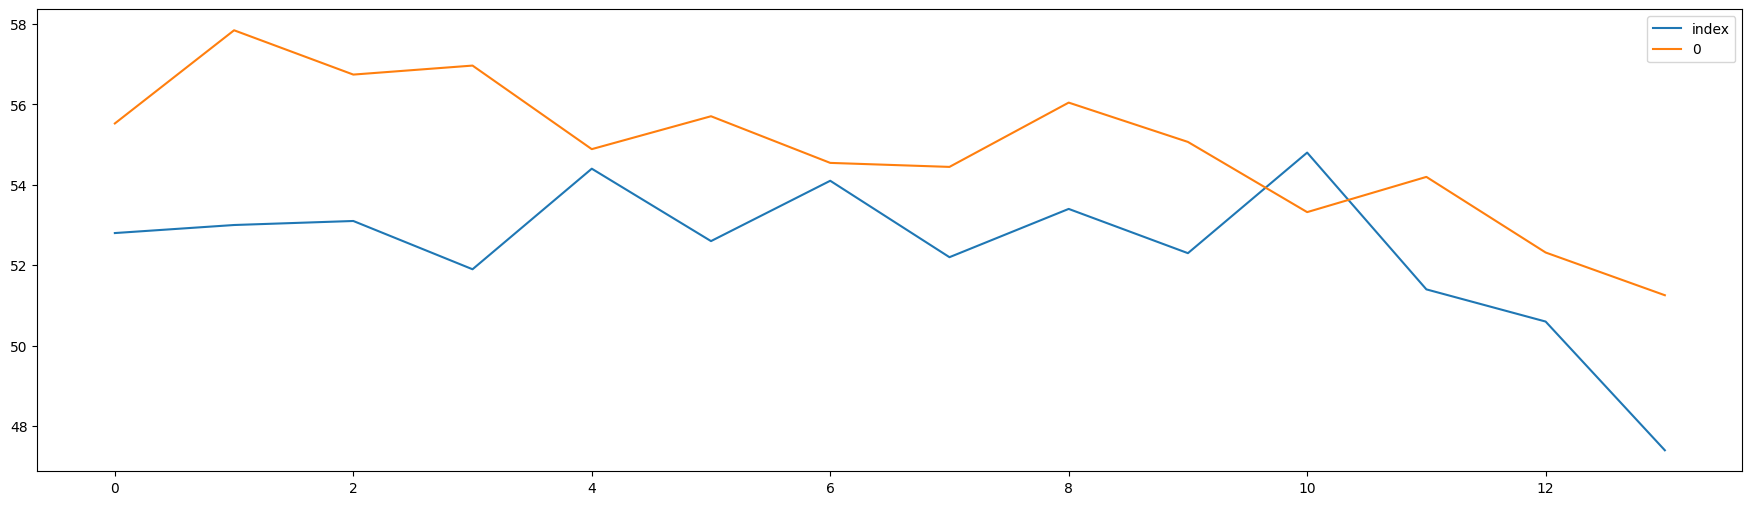

In [48]:
testing.plot(figsize=(22,6))

<Axes: xlabel='date'>

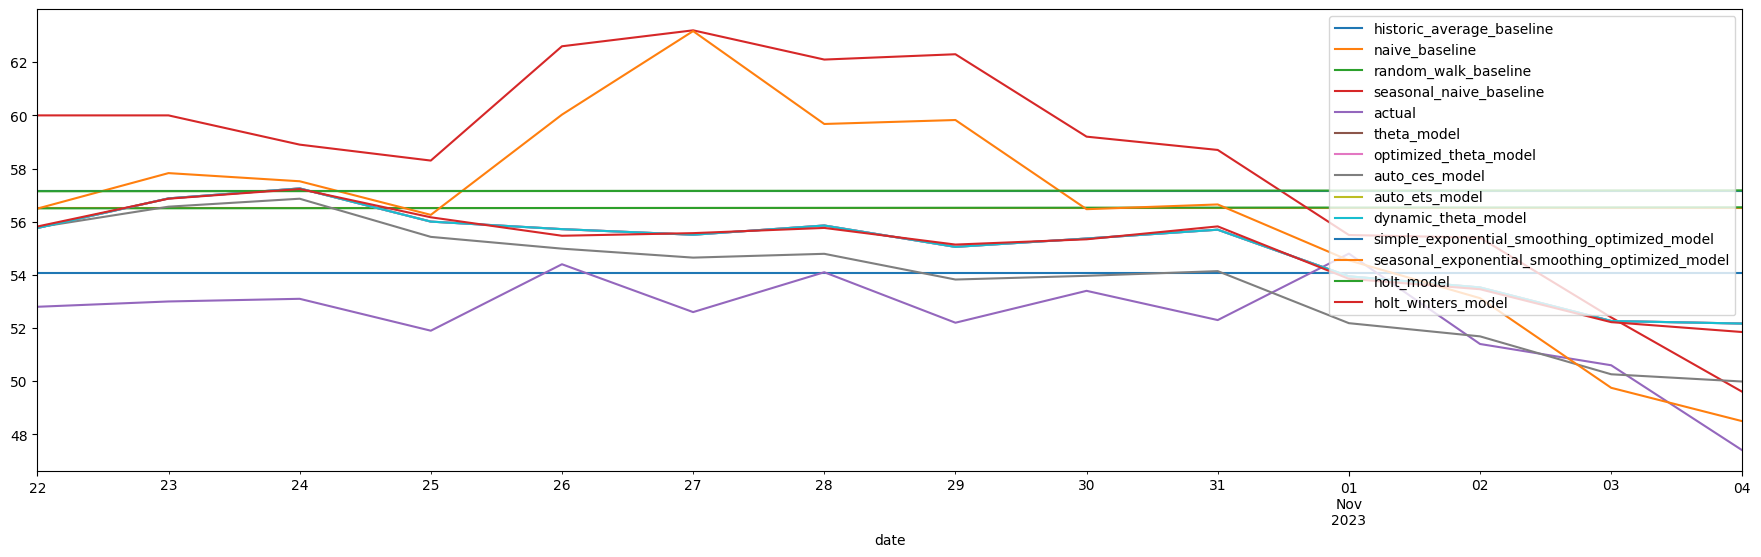

In [49]:
all_predictions.plot(figsize=(22,6))

In [50]:
all_results.sort_values(by='rmse')

,mae,mse,mpe,rmse,mape
auto_ces_model,1.931349,5.242151,0.029140,2.289575,0.036920
historic_average_baseline,1.803386,5.889456,0.032764,2.426820,0.035527
holt_winters_model,2.748188,8.890907,0.050416,2.981762,0.052888
dynamic_theta_model,2.765434,8.964964,0.051024,2.994155,0.053253
optimized_theta_model,2.765610,8.966053,0.051028,2.994337,0.053257
theta_model,2.765956,8.968188,0.051036,2.994693,0.053263
naive_baseline,4.071429,19.735714,0.078960,4.442490,0.078960
random_walk_baseline,4.093821,19.940370,0.079392,4.465464,0.079392
seasonal_exponential_smoothing_optimized_model,4.146080,24.391548,0.075559,4.938780,0.078615
auto_ets_model,4.715267,25.392927,0.091256,5.039140,0.091256


In [51]:
from neuralforecast import NeuralForecast
from neuralforecast.losses.pytorch import MAE
from neuralforecast.auto import (
    AutoRNN,
    AutoLSTM,
    AutoGRU,
    AutoTCN,
    AutoDeepAR,
    AutoDilatedRNN,
    AutoMLP,
    AutoNBEATS,
    AutoNBEATSx,
    AutoNHITS,
    AutoTFT,
    AutoVanillaTransformer,
    AutoInformer,
    AutoAutoformer,
    AutoFEDformer,
    AutoPatchTST,
    AutoTimesNet,
    AutoStemGNN,
    AutoHINT,
)

model_list = {
    'AutoRNN':AutoRNN,
    'AutoLSTM':AutoLSTM,
    'AutoGRU':AutoGRU,
    'AutoTCN':AutoTCN,
    # 'AutoDeepAR': AutoDeepAR,
    'AutoDilatedRNN':AutoDilatedRNN,
    'AutoMLP':AutoMLP,
    'AutoNBEATS':AutoNBEATS,
    'AutoNBEATSx':AutoNBEATSx,
    'AutoNHITS':AutoNHITS,
    'AutoTFT':AutoTFT,
    'AutoVanillaTransformer':AutoVanillaTransformer,
    'AutoInformer':AutoInformer,
    'AutoAutoformer':AutoAutoformer,
    'AutoFEDformer':AutoFEDformer,
    'AutoPatchTST':AutoPatchTST,
    'AutoTimesNet':AutoTimesNet,
    'AutoStemGNN':AutoStemGNN,
    'AutoHINT':AutoHINT,
}

In [52]:
new_uni_data = univariant_data.reset_index().rename(columns={'date':'ds', single_column:'y'}).head(1800)
new_uni_data['unique_id'] = 1.0

In [53]:
import matplotlib.pyplot as plt
from time import sleep

# Try different hyperparmeters to improve accuracy.
all_forecasts = {}
for model_name, model in model_list.items():
    print(str(model))
    try:
        models = [model(h=forecast_horizon, backend='ray', num_samples=10, loss=MAE(), config=dict(max_steps=100))]
        nf = NeuralForecast(models=models, freq='D')
        nf.fit(df=new_uni_data[:-forecast_horizon])
        Y_hat_df = nf.predict()
        Y_hat_df = Y_hat_df.reset_index()
        Y_hat_df['actual'] = new_uni_data[-forecast_horizon:]['y'].values
        Y_hat_df.set_index('ds').drop(columns='unique_id').plot()
        all_forecasts[model_name] = Y_hat_df
        plt.show()
    except Exception as e:
        print(e)
        print(f'Failed {model_name}')
        continue


(_train_tune pid=96624) Seed set to 1


Epoch 99:   0%|          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=0.623, train_loss_epoch=0.623]        


(_train_tune pid=96624) Seed set to 1


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 10.64it/s, v_num=0, train_loss_step=0.622, train_loss_epoch=0.623]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 11.49it/s, v_num=0, train_loss_step=0.622, train_loss_epoch=0.623]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=96624) 
Epoch 99: 100%|██████████| 1/1 [00:00<00:00,  8.20it/s, v_num=0, train_loss_step=0.622, train_loss_epoch=0.623, valid_loss=4.790]


(_train_tune pid=96624) Seed set to 1


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 10.87it/s, v_num=0, train_loss_step=0.622, train_loss_epoch=0.623]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=96624) 
Epoch 0:   0%|          | 0/1 [00:00<?, ?it/s]                             


(_train_tune pid=96624) Seed set to 1


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 11.24it/s, v_num=0, train_loss_step=0.622, train_loss_epoch=0.623]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=96624) 
Epoch 99: 100%|██████████| 1/1 [00:00<00:00,  7.75it/s, v_num=0, train_loss_step=0.622, train_loss_epoch=0.622, valid_loss=4.790]


(_train_tune pid=96624) Seed set to 1


Epoch 99:   0%|          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=0.623, train_loss_epoch=0.623]        


(_train_tune pid=96624) Seed set to 1


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 11.11it/s, v_num=0, train_loss_step=0.622, train_loss_epoch=0.623]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 54:   0%|          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=0.635, train_loss_epoch=0.635]        


In [ ]:
get_metrics(Y_hat_df, 'AutoTCN', 'actual')

In [ ]:
results = pd.concat([value for value in all_forecasts.values()], axis=1)
results = results[[col for col in results.columns if 'Auto' in col]+['actual']].T.drop_duplicates().T

In [ ]:
result_metrics = pd.DataFrame([get_metrics(results, col, 'actual') for col in results.columns if 'Auto' in col]).T

In [ ]:
result_metrics.columns = [col for col in results.columns if 'Auto' in col]

<Axes: xlabel='ds'>

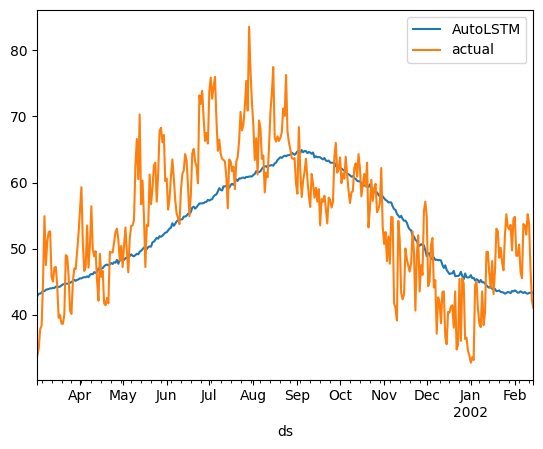

In [ ]:
all_forecasts['AutoLSTM'].set_index('ds').drop(columns='unique_id').plot()

In [ ]:
result_metrics

,AutoRNN,AutoLSTM,AutoGRU,AutoTCN,AutoDilatedRNN
mae,4.991888,6.614404,6.695114,5.702781,8.322464
mse,41.795508,68.947455,68.235014,51.779972,101.441493
mpe,-0.019974,-0.020885,-0.057276,-0.055010,-0.012937
rmse,6.464945,8.303460,8.260449,7.195830,10.071817
mape,0.092641,0.122221,0.119790,0.103991,0.154837
